In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from collections import Counter

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import shutil
from collections import Counter

dataset_dir = './gdrive/My Drive/DSCI631/images'

# List all the .jpg files in the dataset folder
image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

def get_breed_label(filename):
    # Split filename on underscores, remove the last part (identifier number)
    name_parts = filename.split('_')[:-1]

    # Join the breed parts back together to form the full breed name (e.g., "English Setter")
    breed_name = ' '.join(name_parts).capitalize()
    return breed_name

# Create subfolders and move files
for img_file in image_files:
    breed = get_breed_label(img_file)
    breed_dir = os.path.join(dataset_dir, breed)

    # Create folder if it doesn't exist
    os.makedirs(breed_dir, exist_ok=True)

    # Move image to its folder
    src = os.path.join(dataset_dir, img_file)
    dst = os.path.join(breed_dir, img_file)
    shutil.move(src, dst)

In [3]:
import os
from collections import defaultdict

dataset_dir = './gdrive/My Drive/DSCI631/images'
# Initialize a dictionary to store counts
breed_counts = defaultdict(int)

# Loop through each breed subfolder
for breed_name in os.listdir(dataset_dir):
    breed_path = os.path.join(dataset_dir, breed_name)
    if os.path.isdir(breed_path):
        jpg_files = [f for f in os.listdir(breed_path) if f.lower().endswith('.jpg')]
        breed_counts[breed_name] = len(jpg_files)

# Sort by breed name and print
for breed in sorted(breed_counts):
    print(f"{breed}: {breed_counts[breed]} images")

# Total image count (sanity check)
total_images = sum(breed_counts.values())
print(f"\nTotal images: {total_images}")

Abyssinian: 200 images
American bulldog: 200 images
American pit bull terrier: 200 images
Basset hound: 200 images
Beagle: 200 images
Bengal: 200 images
Birman: 200 images
Bombay: 200 images
Boxer: 200 images
British shorthair: 200 images
Chihuahua: 200 images
Egyptian mau: 200 images
English cocker spaniel: 200 images
English setter: 200 images
German shorthaired: 200 images
Great pyrenees: 200 images
Havanese: 200 images
Japanese chin: 200 images
Keeshond: 200 images
Leonberger: 200 images
Maine coon: 200 images
Miniature pinscher: 200 images
Newfoundland: 200 images
Persian: 200 images
Pomeranian: 200 images
Pug: 200 images
Ragdoll: 200 images
Russian blue: 200 images
Saint bernard: 200 images
Samoyed: 200 images
Scottish terrier: 199 images
Shiba inu: 200 images
Siamese: 200 images
Sphynx: 200 images
Staffordshire bull terrier: 191 images
Wheaten terrier: 200 images
Yorkshire terrier: 200 images

Total images: 7390


In [4]:
import tensorflow as tf

# key hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 10

# Constants Setup
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
# Load dataset
dataset_dir = './gdrive/My Drive/DSCI631/images'

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

print("Class Names:", dataset.class_names)

Found 7390 files belonging to 37 classes.
Class Names: ['Abyssinian', 'American bulldog', 'American pit bull terrier', 'Basset hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British shorthair', 'Chihuahua', 'Egyptian mau', 'English cocker spaniel', 'English setter', 'German shorthaired', 'Great pyrenees', 'Havanese', 'Japanese chin', 'Keeshond', 'Leonberger', 'Maine coon', 'Miniature pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian blue', 'Saint bernard', 'Samoyed', 'Scottish terrier', 'Shiba inu', 'Siamese', 'Sphynx', 'Staffordshire bull terrier', 'Wheaten terrier', 'Yorkshire terrier']


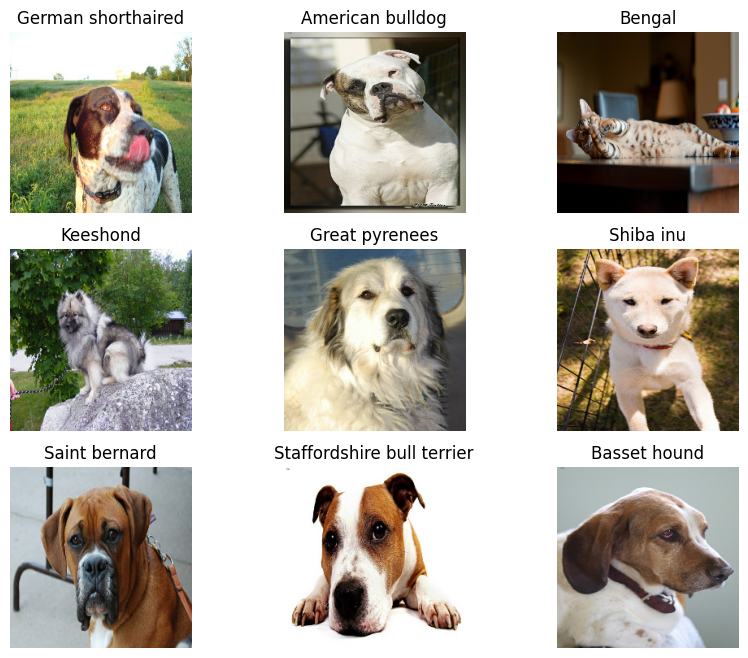

In [6]:
import os
import matplotlib.pyplot as plt

# Visualize Sample Images and Labels after resizing
class_names = dataset.class_names

for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Shuffle the dataset before splitting
dataset = dataset.shuffle(1000, seed=42)

# Get total number of batches
total_batches = tf.data.experimental.cardinality(dataset).numpy()

# Calculate split sizes
train_size = int(0.8 * total_batches)
val_size = int(0.1 * total_batches)

# Perform the split
train_set_raw = dataset.take(train_size)
val_test = dataset.skip(train_size)
valid_set_raw = val_test.take(val_size)
test_set_raw = val_test.skip(val_size)

In [8]:
# Prefetch and cache for performance
train_set_raw = train_set_raw.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
valid_set_raw = valid_set_raw.cache().prefetch(tf.data.AUTOTUNE)
test_set_raw = test_set_raw.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
print("Train batches:", tf.data.experimental.cardinality(train_set_raw).numpy())
print("Val batches:", tf.data.experimental.cardinality(valid_set_raw).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_set_raw).numpy())

Train batches: 184
Val batches: 23
Test batches: 24


In [10]:
# Preprocessing pipeline: resize and rescale
preprocess = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

# Data augmentation pipeline (training only)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomContrast(0.2)
])

# Apply preprocessing + augmentation to training set
train_set = train_set_raw.map(lambda x, y: (preprocess(x), y))
valid_set = valid_set_raw.map(lambda x, y: (preprocess(x), y))
test_set = test_set_raw.map(lambda x, y: (preprocess(x), y))


In [ ]:
for images, labels in train_set.take(1):
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())
    print("Mean pixel value:", tf.reduce_mean(images).numpy())

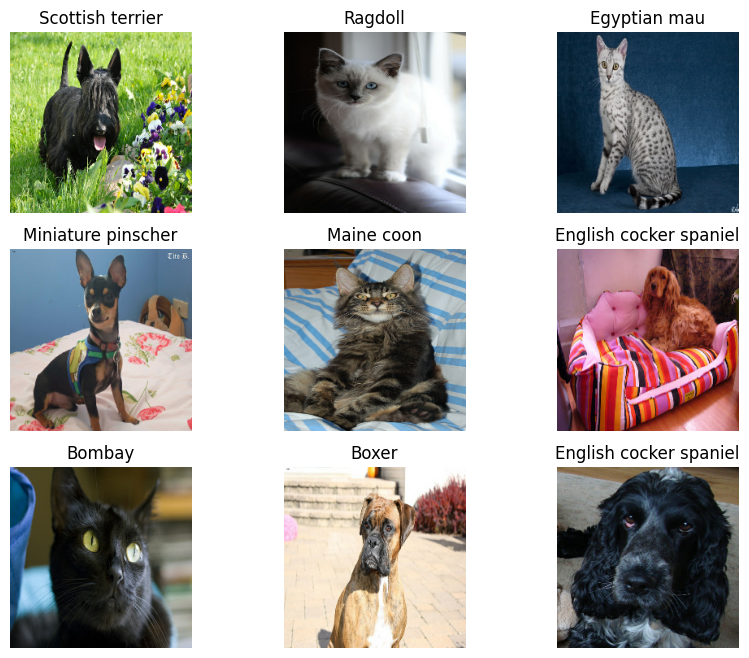

In [11]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in valid_set_raw.take(1):
    plt.figure(figsize=(10, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
import tensorflow as tf
from functools import partial
from tensorflow.keras import models, layers


def build_baseline_cnn(input_shape=INPUT_SHAPE, num_classes=37):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape = input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')

])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
# Build the model
model = build_baseline_cnn()
# Show model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,365 (810.02 KB)

 Trainable params: 207,365 (810.02 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    train_set,
    epochs = EPOCHS,
    validation_data = valid_set
)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.0260 - loss: 3.6128 - val_accuracy: 0.0340 - val_loss: 3.6004
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.0670 - loss: 3.5098 - val_accuracy: 0.1060 - val_loss: 3.2821
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.1349 - loss: 3.1615 - val_accuracy: 0.1970 - val_loss: 2.9678
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.1822 - loss: 2.9121 - val_accuracy: 0.2378 - val_loss: 2.7994
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2465 - loss: 2.6992 - val_accuracy: 0.2582 - val_loss: 2.6096
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3040 - loss: 2.4882 - val_accuracy: 0.3193 - val_loss: 2.3415
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3678 - loss: 2.2074 - val_accuracy: 0.3655 - val_loss: 2.2299
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.4139 - loss: 2.0141 - val_acc

In [ ]:
# Save Baseline CNN
model.save("./gdrive/My Drive/DSCI631/baseline_cnn_model.h5")

# Plot Training vs. Validation Accuracy and Loss

Training accuracy is much higher than validation → model is overfitting.

Both are low → model is underfitting or needs better data/architecture.

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5467 - loss: 1.7486

Validation Accuracy: 0.5404


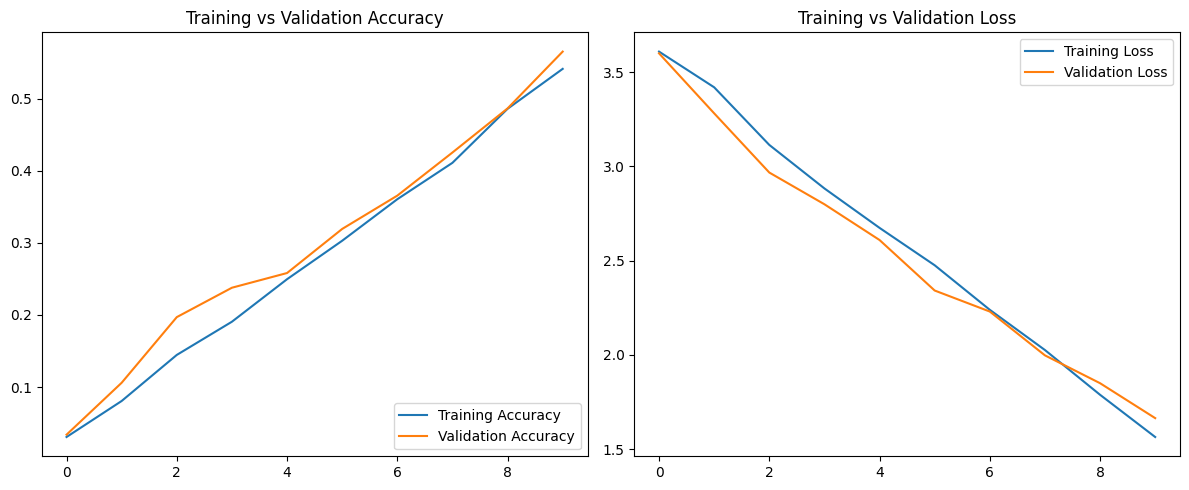

In [26]:
#  Plot Training vs. Validation Accuracy and Loss
import matplotlib.pyplot as plt

v_loss, v_accuracy = model.evaluate(test_set)
print(f"\nValidation Accuracy: {v_accuracy:.4f}")

# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.savefig("train_val_base_model.png", dpi=300)
plt.show()

# Predict on a Batch from the Test Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


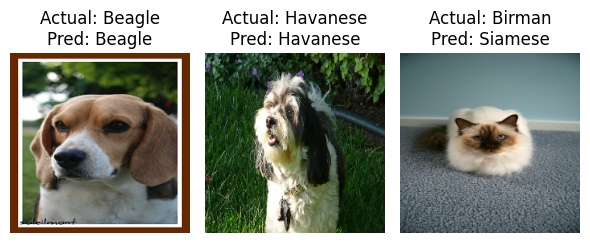

In [29]:
import numpy as np
import matplotlib.pyplot as plt

#class_names = dataset.class_names

# Get one batch from test_set
for images, labels in test_set.take(1):
    preds = model.predict(images)
    predicted_labels = tf.argmax(preds, axis=1)
    break

#  Plot a Few Images with Actual vs. Predicted Labels
plt.figure(figsize=(6, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow((images[i] * 255).numpy().astype("uint8"))
    plt.title(f"Actual: {class_names[labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()



# Get All True & Predicted Labels from the Test Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


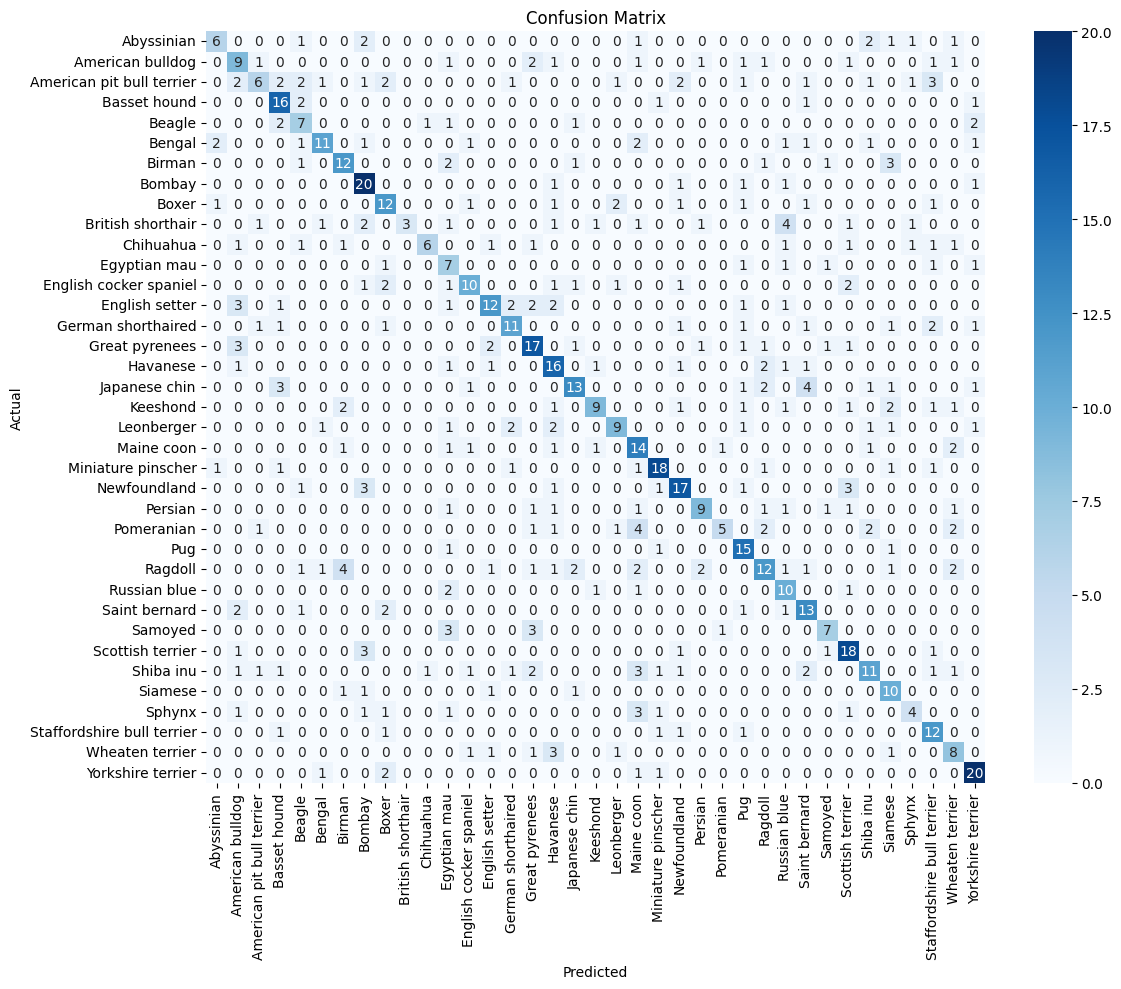

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plot_dir='./gdrive/My Drive/DSCI631'

y_true = []
y_pred = []

for images, labels in test_set:
    preds = model.predict(images)
    predicted_labels = tf.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype(int)
#class_names = dataset.class_names

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{plot_dir}/confusion_matrix_base_model.png", dpi=300)
plt.show()

# Pretrained Models
To compare MobileNetV2, Xception, and EfficientNet effectively, we’ll follow these steps for each:

- Load the base model (without top)

- Freeze the base model

- Add a custom classification head

- Compile and train the model

- Evaluate on test set

- Store accuracy/loss for comparison

In [13]:
preprocess_mobilenet = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet.preprocess_input)
])

preprocess_xcep = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

preprocess_efnet = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)
])

# --- MobileNetV2 ---
train_set_mobilenet = train_set_raw.map(lambda X, y: (preprocess_mobilenet(X), y))
valid_set_mobilenet = valid_set_raw.map(lambda X, y: (preprocess_mobilenet(X), y))
test_set_mobilenet  = test_set_raw.map(lambda X, y: (preprocess_mobilenet(X), y))

# --- Xception ---
train_set_xcep = train_set_raw.map(lambda X, y: (preprocess_xcep(X), y))
valid_set_xcep = valid_set_raw.map(lambda X, y: (preprocess_xcep(X), y))
test_set_xcep  = test_set_raw.map(lambda X, y: (preprocess_xcep(X), y))

# --- EfficientNet ---
train_set_efnet = train_set_raw.map(lambda X, y: (preprocess_efnet(X), y))
valid_set_efnet = valid_set_raw.map(lambda X, y: (preprocess_efnet(X), y))
test_set_efnet  = test_set_raw.map(lambda X, y: (preprocess_efnet(X), y))

In [14]:
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def build_transfer_model(base_model, input_shape=INPUT_SHAPE, num_classes=37):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
xception_base = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

mobilenet_model = build_transfer_model(mobilenet_base)
xception_model = build_transfer_model(xception_base)
efficientnet_model = build_transfer_model(efficientnet_base)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
history_mobilenet = mobilenet_model.fit(train_set_mobilenet, epochs=EPOCHS, validation_data=valid_set_mobilenet)


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.4447 - loss: 2.1269 - val_accuracy: 0.9185 - val_loss: 0.2966
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8524 - loss: 0.4923 - val_accuracy: 0.9293 - val_loss: 0.2121
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8818 - loss: 0.3790 - val_accuracy: 0.9416 - val_loss: 0.1677
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9095 - loss: 0.2961 - val_accuracy: 0.9592 - val_loss: 0.1311
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9196 - loss: 0.2478 - val_accuracy: 0.9647 - val_loss: 0.1177
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9380 - loss: 0.1844 - val_accuracy: 0.9728 - val_loss: 0.0984
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9415 - loss: 0.1884 - val_accuracy: 0.9783 - val_loss: 0.0876
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9523 - loss: 0.1454 - val_acc

In [ ]:
# Save MobileNetV2 model
mobilenet_model.save("./gdrive/My Drive/DSCI631/mobilenetv2_model.h5")

In [18]:
history_xception = xception_model.fit(train_set_xcep, epochs=EPOCHS, validation_data=valid_set_xcep)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - accuracy: 0.5484 - loss: 1.7803 - val_accuracy: 0.9076 - val_loss: 0.2992
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.8573 - loss: 0.4647 - val_accuracy: 0.9103 - val_loss: 0.2672
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.8804 - loss: 0.3686 - val_accuracy: 0.9266 - val_loss: 0.2126
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.9076 - loss: 0.2963 - val_accuracy: 0.9443 - val_loss: 0.1735
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.9152 - loss: 0.2503 - val_accuracy: 0.9497 - val_loss: 0.1666
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.9199 - loss: 0.2330 - val_accuracy: 0.9579 - val_loss: 0.1390
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.9282 - loss: 0.2103 - val_accuracy: 0.9565 - val_loss: 0.1296
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.9391 - loss: 0

In [ ]:
# Save Xception model
xception_model.save("./gdrive/My Drive/DSCI631/xception_model.h5")

In [16]:
history_efficientnet = efficientnet_model.fit(train_set_efnet, epochs=EPOCHS, validation_data=valid_set_efnet)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 194ms/step - accuracy: 0.5237 - loss: 1.9404 - val_accuracy: 0.9293 - val_loss: 0.2479
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8852 - loss: 0.4060 - val_accuracy: 0.9484 - val_loss: 0.1536
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9020 - loss: 0.3019 - val_accuracy: 0.9511 - val_loss: 0.1400
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9284 - loss: 0.2192 - val_accuracy: 0.9701 - val_loss: 0.1039
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9307 - loss: 0.2114 - val_accuracy: 0.9660 - val_loss: 0.0954
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9476 - loss: 0.1709 - val_accuracy: 0.9742 - val_loss: 0.0834
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9454 - loss: 0.1573 - val_accuracy: 0.9783 - val_loss: 0.0707
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9554 - loss: 0.1373 - val_ac

In [19]:
results = {
    "MobileNetV2": mobilenet_model.evaluate(test_set_mobilenet, verbose=0),
    "Xception": xception_model.evaluate(test_set_xcep, verbose=0),
    "EfficientNetB0": efficientnet_model.evaluate(test_set_efnet, verbose=0)
}

for model_name, (loss, accuracy) in results.items():
    print(f"{model_name} -> Test Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

MobileNetV2 -> Test Accuracy: 0.9727, Loss: 0.0923
Xception -> Test Accuracy: 0.9609, Loss: 0.1232
EfficientNetB0 -> Test Accuracy: 0.9753, Loss: 0.0731


In [ ]:
# Save Baseline CNN
model.save("./gdrive/My Drive/DSCI631/baseline_cnn_model.h5")

# Save MobileNetV2 model
mobilenet_model.save("./gdrive/My Drive/DSCI631/mobilenetv2_model.h5")

# Save Xception model
xception_model.save("./gdrive/My Drive/DSCI631/xception_model.h5")

# Save EfficientNet model
efficientnet_model.save("./gdrive/My Drive/DSCI631/efficientnet_model.h5")

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model("baseline_cnn_model.h5")

model.fit(
    train_set,
    validation_data=valid_set,
    epochs=20,              # Total desired epochs
    initial_epoch=10        # Resume from epoch 10
)

# Plotting Accuracy and Loss

In [20]:
def plot_histories(histories, titles, plot_dir='./gdrive/My Drive/DSCI631'):
    for history, title in zip(histories, titles):
        plt.figure(figsize=(14, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label='Val')
        plt.title(f'{title} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], linestyle='--', label='Val')
        plt.title(f'{title} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        save_path = f"{plot_dir}/{title.replace(' ', '_').lower()}_history.png"
        plt.savefig(save_path, dpi=300)
        plt.show()

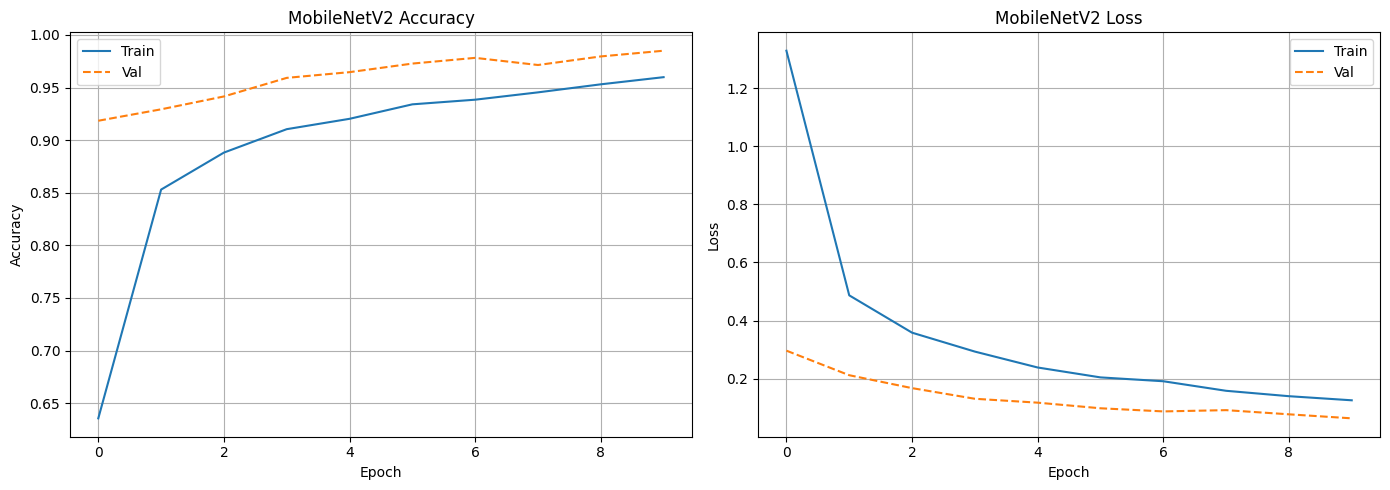

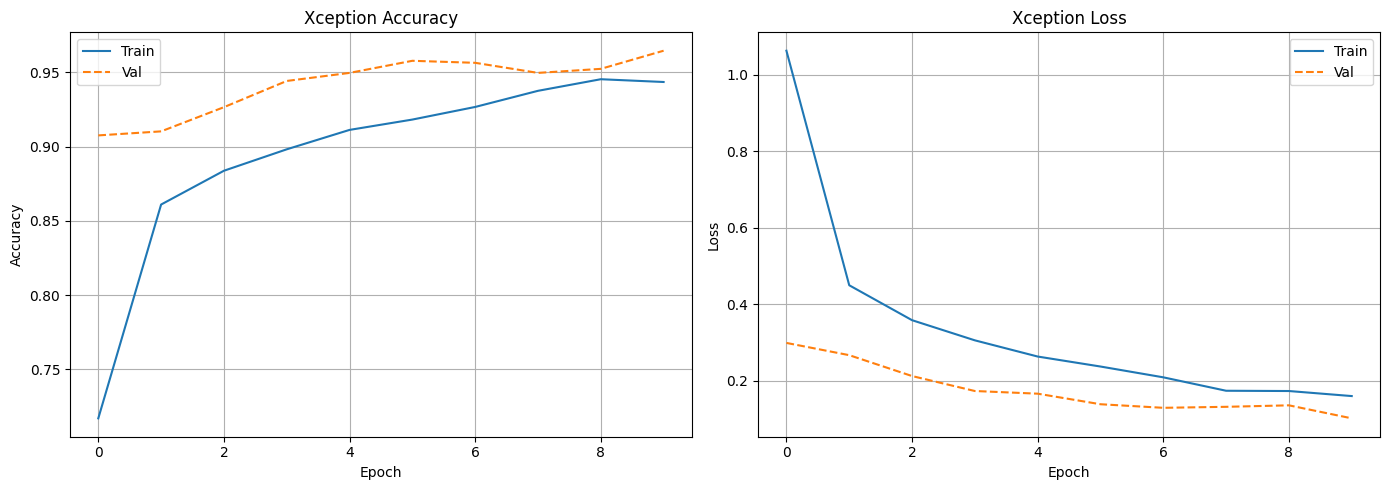

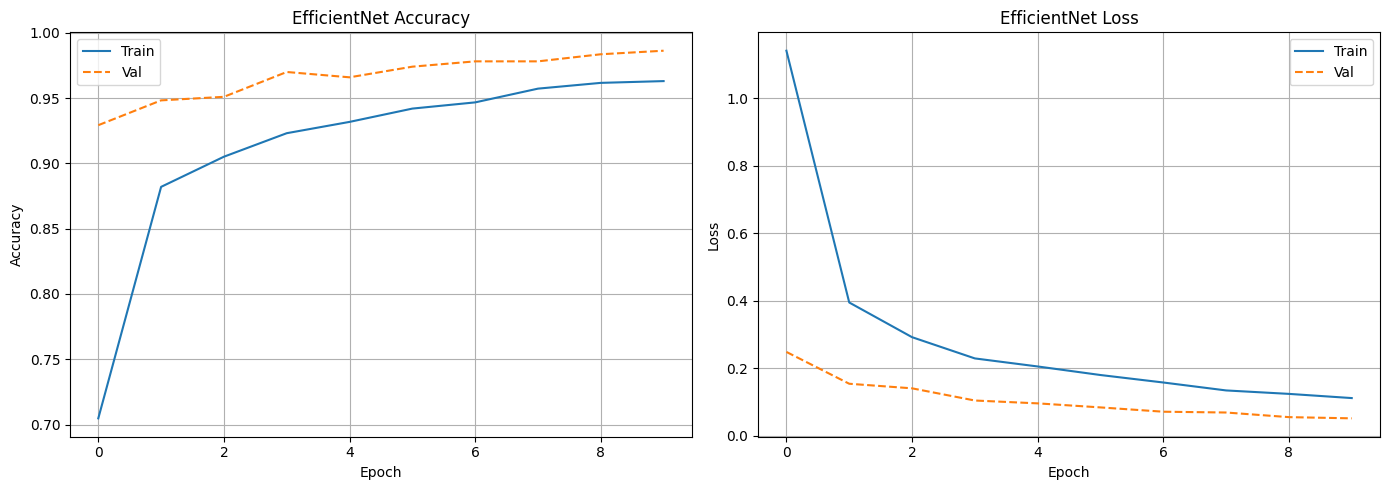

In [21]:
# plot histories
plot_histories(
    histories=[history_mobilenet, history_xception, history_efficientnet],
    titles=['MobileNetV2', 'Xception', 'EfficientNet']
)

# Confusion Matrices

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrices(y_true, y_preds, model_names, class_names, plot_dir='./gdrive/My Drive/DSCI631'):

    for i, (y_pred, name) in enumerate(zip(y_preds, model_names)):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(12, 10))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                  xticklabels=class_names, yticklabels=class_names)
      plt.title(f'{name} Confusion Matrix')
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.xticks(rotation=90)
      plt.yticks(rotation=0)
      plt.tight_layout()
      plt.savefig(f"{plot_dir}/confusion_matrix_{name.replace(' ', '_').lower()}.png", dpi=300)
      plt.show()

In [23]:
y_true = []
y_pred_mobilenet = []
y_pred_xception = []
y_pred_efficientnet = []

# Collect ground truth and MobileNet predictions
for images, labels in test_set_mobilenet:
    preds_mobilenet = mobilenet_model.predict(images)
    pred_labels_mobilenet = tf.argmax(preds_mobilenet, axis=1)

    y_true.extend(labels.numpy())
    y_pred_mobilenet.extend(pred_labels_mobilenet.numpy())

# Use same ground truth length for the next predictions
for images, labels in test_set_xcep:
    preds_xception = xception_model.predict(images)
    pred_labels_xception = tf.argmax(preds_xception, axis=1)

    y_pred_xception.extend(pred_labels_xception.numpy())

for images, labels in test_set_efnet:
    preds_efficientnet = efficientnet_model.predict(images)
    pred_labels_efficientnet = tf.argmax(preds_efficientnet, axis=1)

    y_pred_efficientnet.extend(pred_labels_efficientnet.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━

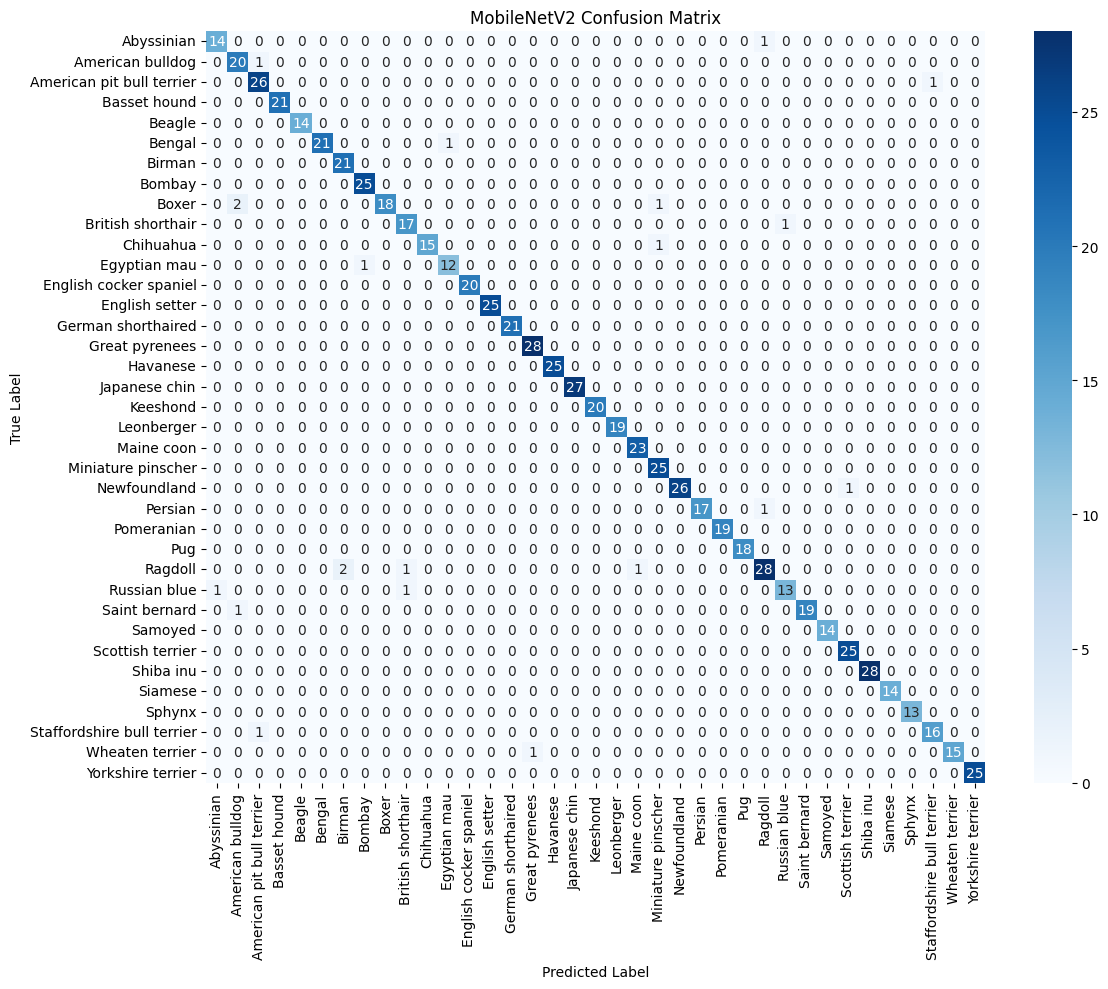

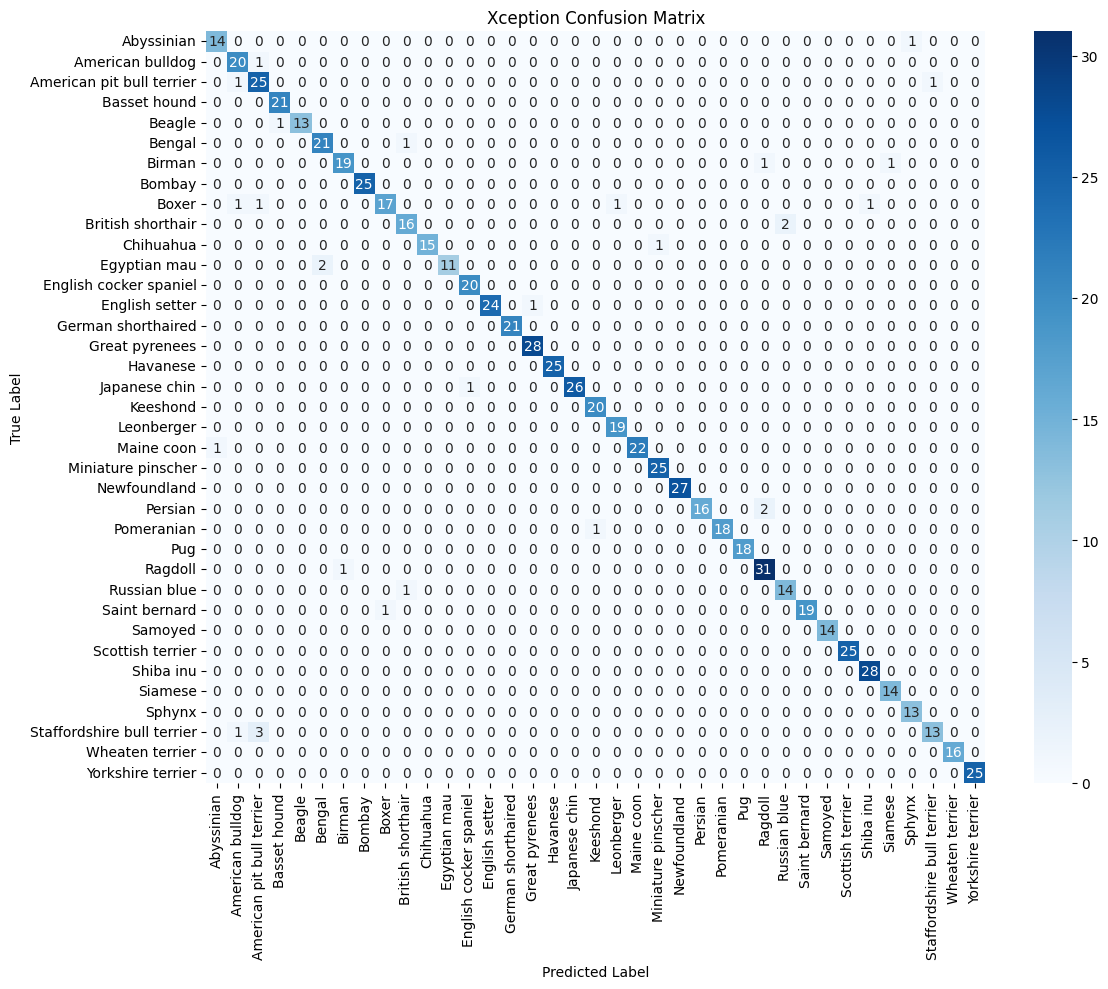

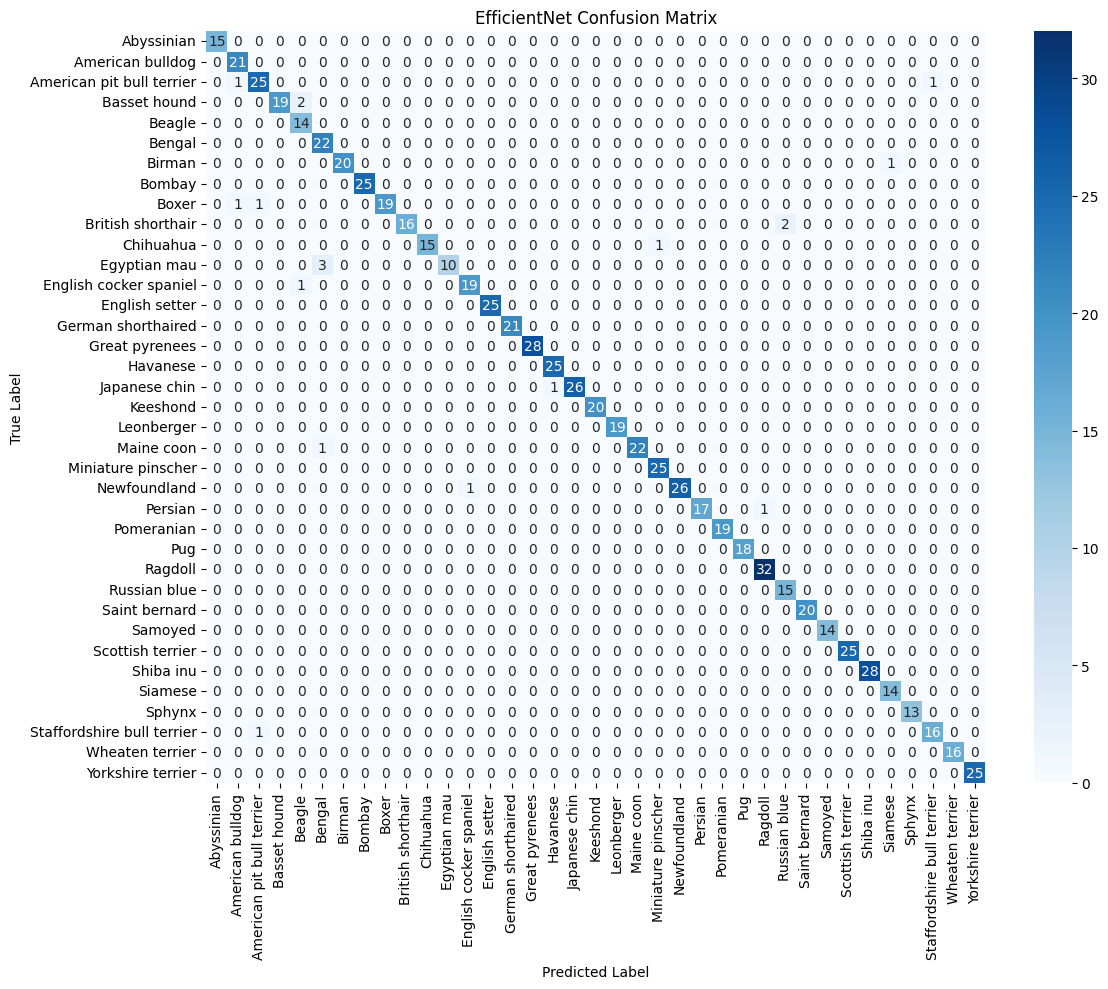

In [24]:
plot_confusion_matrices(
    y_true=y_true,  # same across models
    y_preds=[y_pred_mobilenet, y_pred_xception, y_pred_efficientnet],
    model_names=['MobileNetV2', 'Xception', 'EfficientNet'],
    class_names=class_names
)

# KNN on Image Data
We'll use a pretrained model like MobileNetV2 (without the top layer) to convert each image into a fixed-size feature vector.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load MobileNetV2 without top layer
feature_extractor = MobileNetV2(include_top=False, input_shape=(128, 128, 3), pooling='avg', weights='imagenet')

In [ ]:
# Extract Features from Train and Test Sets
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        preprocessed = preprocess_input(images)
        f = feature_extractor.predict(preprocessed)
        features.append(f)
        labels.append(lbls.numpy())
    return np.vstack(features), np.concatenate(labels)

X_train, y_train = extract_features(train_set)
X_test, y_test = extract_features(test_set)

In [ ]:
# Fit KNN Classifier

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)


In [ ]:
# Evaluate

y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn, target_names=class_names))

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_knn, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# PCA visualization of CNN-extracted features

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

In [ ]:
import numpy as np

plt.figure(figsize=(12, 10))

# Choose some colors for classes (adjust if you have many classes)
colors = plt.cm.get_cmap('tab20', len(class_names))

for i, class_name in enumerate(class_names):
    idxs = np.where(y_train == i)
    plt.scatter(X_train_pca[idxs, 0], X_train_pca[idxs, 1],
                label=class_name, alpha=0.5, color=colors(i))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Image Features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for i, class_name in enumerate(class_names):
    idxs = np.where(y_train == i)
    ax.scatter(X_train_pca_3d[idxs, 0], X_train_pca_3d[idxs, 1], X_train_pca_3d[idxs, 2],
               label=class_name, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.title('3D PCA Projection of Image Features')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Visual clusters showing how well the model’s extracted features separate different breeds/classes.

If classes overlap a lot, that might explain confusion/errors and point to where you could improve.

# Plot Accuracy Comparison of Baseline CNN vs Pretrained Models

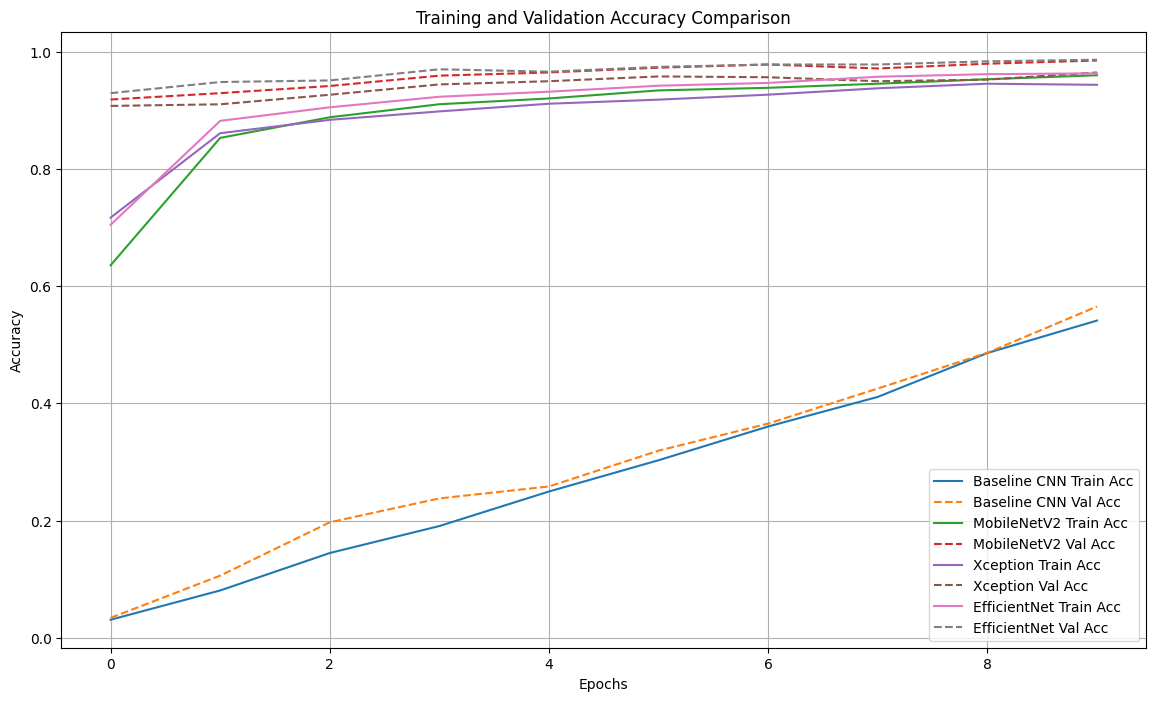

In [31]:
import matplotlib.pyplot as plt

def plot_accuracy_comparison(histories, labels, epochs):
    plt.figure(figsize=(14, 8))

    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f"{label} Train Acc")
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f"{label} Val Acc")

    plt.title('Training and Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_accuracy_comparison(
    histories=[history, history_mobilenet, history_xception, history_efficientnet],
    labels=['Baseline CNN', 'MobileNetV2', 'Xception', 'EfficientNet'],
    epochs=EPOCHS
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


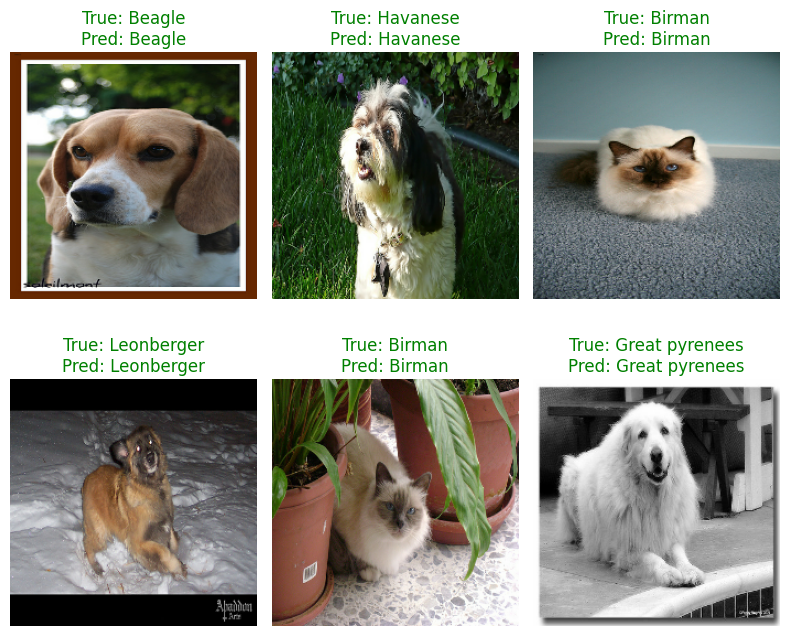

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a few predictions for a given model
def show_predictions(model, dataset, class_names, title, num_images=6):
    rows = 2
    cols = 3
    plt.figure(figsize=(8, 7))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        pred_labels = tf.argmax(preds, axis=1)
        for i in range(num_images):
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow((images[i]).numpy().astype("uint8"))
            actual = class_names[labels[i]]
            predicted = class_names[pred_labels[i]]
            color = "green" if actual == predicted else "red"
            ax.set_title(f"True: {actual}\nPred: {predicted}", color=color)
            plt.axis("off")
    #plt.suptitle(f"Sample Predictions - {title}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage for each model
#show_predictions(mobilenet_model, test_set_mobilenet, class_names, "MobileNetV2")
#show_predictions(xception_model, test_set_xcep, class_names, "Xception")
show_predictions(efficientnet_model, test_set_efnet, class_names, "EfficientNetB0")